In [1]:
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import os, random, sys
from data_preprocessing import create_data_generators
import json
from sklearn.metrics import confusion_matrix
from test_resizing import resize_to_square

# from analyse_results import load_image, generate_data_generators
# from analyse_results import load_model, print_confusion_matrix

In [2]:
RESULTS_FOLDER = "../saved_models/BEST_OF_THE_BEST/Trained_lhcbgpu_inception_v3_300_lr0001/20190620_1021"
#RESULTS_FOLDER = "../saved_models/20190612_1048"
HYPERPARAMS_FILE =  RESULTS_FOLDER+ '/hyperparams.json'

with open(HYPERPARAMS_FILE, "r") as read_file:
    data = json.load(read_file)

HYPERPARAMS = data['hyperparameters'][0]
BATCHSIZE = HYPERPARAMS['BATCHSIZE']

#20190612_1048
if (os.getcwd() == '/home/kalkami/translearn'):
    #lhcpgpu1
    TRAIN_DIR = '/data/IntelliGate/kalkami/DATASETS/carsStanford_all/train'
    TEST_DIR = '/data/IntelliGate/kalkami/DATASETS/carsStanford_all/test'
    TRAIN_DIR_TST = TRAIN_DIR
    TEST_DIR_TST = TEST_DIR
else:
    #local
    TRAIN_DIR = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/train'
    TEST_DIR = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test'
    TRAIN_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/train'
    TEST_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test'
    TEST_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/CARS_GOOGLE_IMG/downloads'



In [3]:
def load_image(img_path, input_shape, show=False):
    image_resized = resize_to_square(input_shape[1], img_path)
    img_org = image.load_img(img_path)
    img = image_resized
    #img = image.load_img(image_resized, target_size=input_shape)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_org)                           
        plt.axis('off')
        plt.show()

    return img_tensor


        
def generate_data_generators(input_shape):
    generator_train, generator_test = create_data_generators(input_shape, BATCHSIZE, 
                                                                TRAIN_DIR, TEST_DIR, 
                                                                save_augumented=None, 
                                                                plot_imgs = False)
    return generator_train, generator_test
        
        
def load_model(results_folder):
    # load json and create model
    json_file = open(results_folder + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(results_folder + "/weights.best.hdf5")
    input_shape = loaded_model.layers[0].output_shape[1:3]
    print("Loaded model from disk")
    return loaded_model, input_shape



def print_confusion_matrix(cls_pred, cls_test, class_names, cmap=plt.cm.Blues):
    '''Helper-function for printing confusion matrix'''
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    print("Confusion matrix:")
    # Print the confusion matrix as text.
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))
        
##------------------## All above should be transfer to the "analyse_results.py"        
        
def predict(img_path, model, input_shape, class_names, correct_class):
    img_array = load_image(img_path, input_shape)
    preds = model.predict(img_array)
    predictions = decode_predictions(preds, class_names)
    top1_pred = predictions[0][0]
    print(predictions)
    img_org = image.load_img(img_path)
    fig, axs = plt.subplots(1,2)
    axs[0].set_title(correct_class)
    axs[0].imshow(img_org)
    #axs[0].axis('off')

    axs[1].set_title(str(top1_pred))
    axs[1].imshow(img_array[0])
    plt.show()

def decode_predictions(preds, class_names, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

def predict(img_path, model, input_shape, class_names, correct_class):
    img_array = load_image(img_path, input_shape)
    preds = model.predict(img_array)
    predictions = decode_predictions(preds, class_names)
    top1_pred = predictions[0][0]
    print(predictions)
    img_org = image.load_img(img_path)
    fig, axs = plt.subplots(1,2)
    axs[0].set_title(correct_class)
    axs[0].imshow(img_org)
    axs[1].set_title(str(top1_pred))
    axs[1].imshow(img_array[0])
    plt.show()
    #pred_decoded = decode_predictions(pred)[0]
    ## Print the predictions.
    #for code, name, score in pred_decoded:
        #print("{0:>6.2%} : {1}".format(score, name))

def show_model_performance(loaded_model, generator_train, generator_test):
    steps_test = generator_test.n / BATCHSIZE
    steps_train = generator_test.n / BATCHSIZE
    cls_train = generator_train.classes
    cls_test = generator_test.classes
    class_names = list(generator_train.class_indices.keys())
    # Predict the classes for all images in the test-set
    y_pred = loaded_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    # plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred, cls_test, class_names)
    #result = loaded_model.evaluate_generator(generator_test, steps=steps_test)
    #result_train = loaded_model.evaluate_generator(generator_train, steps=steps_train)
    #print("Train-set classification accuracy: {0:.2%}".format(result_train[1]))
    #print("Test-set classification accuracy: {0:.2%}".format(result[1]))
        

def perform_pred(loaded_model, car_class=None, img_pth=None):
    test_dir = TEST_DIR_TST
    results_folder = RESULTS_FOLDER
    
    if os.path.exists(results_folder+'/class_names.txt'):
        class_names = []
        # open file and read the content in a list
        with open(results_folder+'/class_names.txt', 'r') as filehandle:  
            for line in filehandle:
                current_line = line[:-1]
                class_names.append(current_line)
    else:
        generator_train, generator_test = generate_data_generators(results_folder, input_shape)
        class_names = list(generator_train.class_indices.keys())
        print(class_names)
        with open(results_folder+'/class_names.txt', 'w') as filehandle:  
            for listitem in class_names:
                filehandle.write('%s\n' % listitem)
                
    if car_class is None:
        car_class = random.choice(class_names)
    
    if img_pth is None: 
        # randomly select an image from defined class     
        test_dir_full = test_dir + '/' + car_class
        test_img = test_dir_full + '/' + random.choice(os.listdir(test_dir_full))
    else:
        test_img = img_pth
        
    
    input_shape = loaded_model.layers[0].output_shape[1:3]
    
          
    predict(test_img, loaded_model, input_shape, class_names, car_class)

In [4]:
loaded_model, input_shape=load_model(RESULTS_FOLDER)
generator_train, generator_test = generate_data_generators(input_shape)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


Confusion matrix:
(0) AM General Hummer SUV 2000
(1) Acura Integra Type R 2001
(2) Acura RL Sedan 2012
(3) Acura TL Sedan 2012
(4) Acura TL Type-S 2008
(5) Acura TSX Sedan 2012
(6) Acura ZDX Hatchback 2012
(7) Aston Martin V8 Vantage Convertible 2012
(8) Aston Martin V8 Vantage Coupe 2012
(9) Aston Martin Virage Convertible 2012
(10) Aston Martin Virage Coupe 2012
(11) Audi 100 Sedan 1994
(12) Audi 100 Wagon 1994
(13) Audi A5 Coupe 2012
(14) Audi R8 Coupe 2012
(15) Audi RS 4 Convertible 2008
(16) Audi S4 Sedan 2007
(17) Audi S4 Sedan 2012
(18) Audi S5 Convertible 2012
(19) Audi S5 Coupe 2012
(20) Audi S6 Sedan 2011
(21) Audi TT Hatchback 2011
(22) Audi TT RS Coupe 2012
(23) Audi TTS Coupe 2012
(24) Audi V8 Sedan 1994
(25) BMW 1 Series Convertible 2012
(26) BMW 1 Series Coupe 2012
(27) BMW 3 Series Sedan 2012
(28) BMW 3 Series Wagon 2012
(29) BMW 6 Series Convertible 2007
(30) BMW ActiveHybrid 5 Sedan 2012
(31) BMW M3 Coupe 2012
(32) BMW M5 Sedan 2010
(33) BMW M6 Convertible 2010
(34) B

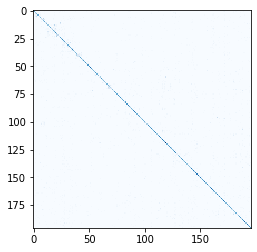

In [5]:
show_model_performance(loaded_model, generator_train, generator_test)

(640, 480)
[[('Cadillac Escalade EXT Crew Cab 2007', 0.31879959), ('GMC Yukon Hybrid SUV 2012', 0.26574287), ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012', 0.19784242), ('Chevrolet Avalanche Crew Cab 2012', 0.10875207), ('Ford Freestar Minivan 2007', 0.028471423)]]


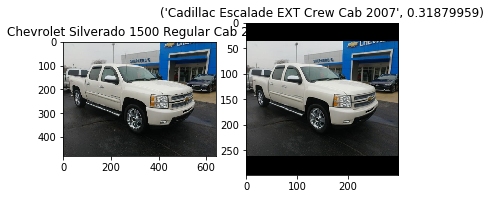

In [6]:
perform_pred(loaded_model)